In [32]:
import os, sys, pickle
import numpy as np
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path = list(set(sys.path))
import matplotlib.pyplot as plt
%matplotlib inline

from results_path import DDPG_PATH, PPO_PATH

from common.evaluate import make_vis_env, test_env

from flow.multiagent_envs import MultiWaveAttenuationMergePOEnv
from flow.scenarios import MergeScenario
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from ray.tune import run_experiments

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.rllib.agents.ddpg import DDPGAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

benchmark_name = 'multi_merge'
AGENT = 'HUMAN' # 'PPO' or 'DDPG' or 'HUMAN'
checkpoint = '50'

In [33]:
ray.init(num_cpus=1, include_webui=False, ignore_reinit_error=True)

Calling ray.init() again after it has already been called.


In [46]:
benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.flow_params
horizon = flow_params['env'].horizon
flow_params['env'].additional_params['t_min'] = 3.0
create_env, env_name = make_create_env(params=flow_params, version=0)

In [47]:
env = create_env()

 Starting SUMO on port 60457


In [48]:
env.env_params.additional_params

{'eta1': 1.0,
 'eta2': 0.1,
 'max_accel': 3,
 'max_decel': 3,
 'reward_scale': 1.0,
 't_min': 3.0,
 'target_velocity': 25}

In [49]:
# calculate the space-time velocity map
left_length = env.k.scenario.edge_length('left')
car_length = 5.0
scale = 10
vel_lists = []
vel_map_lists = []

for _ in range(1):
    state = env.reset()
    vel = []
    for i in range(env.env_params.horizon):
        # record the mean velocity
        v = np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids()))
        vel.append(v)

        # record the velocity map
        ids = env.k.vehicle.get_ids()
        vel_map_ = np.zeros(int(left_length)*scale)
        for id_ in ids:
            pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
            vel_ = env.k.vehicle.get_speed(id_)
            pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
            pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
            vel_map_[pos_bottom:pos_top] = vel_            

        # step the simulation
        rl_ids = env.k.vehicle.get_rl_ids()
        actions = {}
        if AGENT != 'HUMAN':
            for id_ in rl_ids:
                action = agent.compute_action(state[id_])
                actions.update({id_: action})
        state, r, _, _ = env.step(actions)

        if i == 0:
            vel_map_list = vel_map_
        else:
            vel_map_list = np.vstack((vel_map_list, vel_map_))

    vel_lists.append(vel)
    vel_map_list[vel_map_list==0.0] = np.nan
    vel_map_lists.append(vel_map_list)

 Starting SUMO on port 60457


cost1: 0.01599765865209233
cost1: 0.0712757100830584
cost1: 0.08717780269566272
cost1: 0.10307562915667864
cost1: 0.11896885465916206
cost1: 0.134857092473099
cost1: 0.15073989240688707
cost1: 0.1666167290984607
cost1: 0.182486990121244
cost1: 0.20624226839987642
cost1: 0.22207706719443382
cost1: 0.2379024899737676
cost1: 0.253717553881318
cost1: 0.26952114931858134
cost1: 0.28531202821981055
cost1: 0.30108879184060494
cost1: 0.31684987799603953
cost1: 0.3325935476716923
cost1: 0.3483178709156325
cost1: 0.3640207119004329
cost1: 0.3832337463763303
cost1: 0.39683816688783485
cost1: 0.41053539135862194
cost1: 0.4243274424099852
cost1: 0.43195251592079825
cost2: -0.614899073599003
cost1: 0.4433099494775187
cost2: -0.6015083022007143
cost1: 0.45535863118853076
cost2: -0.5901815246944889
cost1: 0.4678496488007039
cost2: -0.5802131646762362
cost1: 0.46989829187769405
cost2: -0.571272875993569
cost1: 0.48034581134654925
cost2: -0.5631686215023726
cost1: 0.4915223694290086
cost2: -0.5557687871

cost1: 0.6848013884071811
cost2: -0.4665346066344099
cost2: -0.4872478204664787
cost1: 0.6833434711819886
cost2: -0.4671353109248679
cost2: -0.4862953121653671
cost1: 0.6888587619956659
cost2: -0.4679874187574191
cost2: -0.48545059081006986
cost1: 0.6945320634896078
cost2: -0.46910365458655007
cost2: -0.4847090361384588
cost1: 0.6819871983729692
cost2: -0.4704715494815715
cost2: -0.48406617573967675
cost1: 0.6872737206600888
cost2: -0.47205574011398105
cost2: -0.4835176445125393
cost1: 0.6927984544729605
cost2: -0.4738058766021204
cost2: -0.4830591495125733
cost1: 0.6984921075269123
cost2: -0.4756670952962571
cost2: -0.4826864402435858
cost1: 0.6828805770696259
cost2: -0.477589464733082
cost2: -0.4823952844761726
cost1: 0.6879570538857758
cost2: -0.4795339544070038
cost2: -0.48218144966683285
cost1: 0.6933494047101388
cost2: -0.4814743183051427
cost2: -0.48204098026298553
cost1: 0.6989526344150307
cost2: -0.4833957374768894
cost2: -0.481970758030714
cost1: 0.7047064484297015
cost2: -0.

cost1: 0.5383076055004062
cost2: -0.445604690405327
cost2: -0.4785845814468032
cost1: 0.5383266269485327
cost2: -0.4472865839481521
cost2: -0.47818083854823973
cost1: 0.5385167937108111
cost2: -0.448724780561706
cost2: -0.4778478662151542
cost1: 0.5329605710876606
cost2: -0.4499772277951611
cost2: -0.47758320167526946
cost1: 0.5328572138651453
cost2: -0.4510826998126614
cost2: -0.47738434835077687
cost1: 0.5332340109158775
cost2: -0.4520636552518786
cost2: -0.477248772284397
cost1: 0.5338847746461302
cost2: -0.45292985200985986
cost2: -0.47717390912543006
cost1: 0.5347161929522831
cost2: -0.45368176972720514
cost2: -0.4771571851428758
cost1: 0.5301553655308214
cost2: -0.4543135686390909
cost2: -0.47719605709649277
cost1: 0.5311300893613254
cost2: -0.45481562825281857
cost2: -0.47728807761305303
cost1: 0.5322782354027116
cost2: -0.4551768092767743
cost2: -0.47743099505855496
cost1: 0.5335624318274614
cost2: -0.45538656813080863
cost2: -0.47762289980451683
cost1: 0.529655305509268
cost2:

cost1: 0.412833301838411
cost2: -0.07096113062764786
cost2: -0.4944773628486057
cost2: -0.47942166110421397
cost1: 0.4101853230272714
cost2: -0.0864094811562827
cost2: -0.49459352086842073
cost2: -0.47933988873373296
cost1: 0.4080684737832768
cost2: -0.10293553135686621
cost2: -0.49425564983872433
cost2: -0.47933958162052903
cost1: 0.4061074478567777
cost2: -0.11955430988476194
cost2: -0.4933231765667756
cost2: -0.4794292827992579
cost1: 0.4042700945589113
cost2: -0.1356335308880657
cost2: -0.49164057107520415
cost2: -0.4796212005358691
cost1: 0.40245682203038
cost2: -0.15080512948537272
cost2: -0.48905101817837243
cost2: -0.47993181993335243
cost1: 0.4008027998814747
cost2: -0.164884520616857
cost2: -0.48540859409222414
cost2: -0.48038229408283417
cost1: 0.399310094903102
cost2: -0.17780709059933741
cost2: -0.4805845292135628
cost2: -0.48099834070910513
cost1: 0.3979414344443902
cost2: -0.18958233415722603
cost2: -0.47446602823137374
cost2: -0.4818092761772647
cost1: 0.396671434200030

cost1: 0.2994034504332104
cost2: 0.0
cost2: -0.22103368927664727
cost2: -0.27715771302436903
cost2: -0.47289862034521435
cost1: 0.30005915541639366
cost2: 0.0
cost2: -0.23534922553691295
cost2: -0.2315468308072668
cost2: -0.4709444686135839
cost1: 0.2983686941807244
cost2: 0.0
cost2: -0.24863193933525288
cost2: -0.1766921661510986
cost2: -0.46929526844300873
cost1: 0.288801644707702
cost2: 0.0
cost2: -0.260970843434064
cost2: -0.11109413589001009
cost2: -0.4680697513613699
cost1: 0.2870957795757454
cost2: 0.0
cost2: -0.27244996565066915
cost2: -0.0334246151532378
cost2: -0.4674245188489911
cost1: 0.28816434439391053
cost2: 0.0
cost2: -0.28314984535648674
cost2: 0.0
cost2: -0.4675399856025342
cost1: 0.2865824897339679
cost2: 0.0
cost2: -0.2931501269864709
cost2: 0.0
cost2: -0.4685824732947057
cost1: 0.2851187487353786
cost2: 0.0
cost2: -0.3025336912681487
cost2: 0.0
cost2: -0.4706423588319666
cost1: 0.2837496066524278
cost2: 0.0
cost2: -0.31139299714486857
cost2: 0.0
cost2: -0.473666897

cost1: 0.26170472846596216
cost2: -0.5021527410247092
cost2: -0.3759229791731456
cost2: -0.3708820986814705
cost2: -0.17848914536374968
cost2: 0.0
cost1: 0.25533138846160364
cost2: -0.5009730557621911
cost2: -0.3780179495730857
cost2: -0.3592325901718055
cost2: -0.19681581155008798
cost2: 0.0
cost1: 0.25532816064101554
cost2: -0.5002500401114461
cost2: -0.3799777401557063
cost2: -0.34786150691672063
cost2: -0.21352615475305603
cost2: 0.0
cost1: 0.25533946269853486
cost2: -0.5001426121617474
cost2: -0.38178586294335054
cost2: -0.33713065954201094
cost2: -0.22881653951473346
cost2: 0.0
cost1: 0.2574644622610956
cost2: -0.5008052819707652
cost2: -0.38343487793892067
cost2: -0.3273822791111091
cost2: -0.24285380831833722
cost2: 0.0
cost1: 0.2571394571727656
cost2: -0.5023070275723102
cost2: -0.38492203028513705
cost2: -0.31890909715429167
cost2: -0.25578076004623024
cost1: 0.25698691651765637
cost2: -0.5045270578612258
cost2: -0.38624818704693714
cost2: -0.3119292668554093
cost2: -0.267720

cost1: 0.26582933755489213
cost2: -0.04708886885793747
cost2: -0.36397525606356
cost2: -0.3151893091577486
cost2: -0.4298972267292682
cost1: 0.26984341516717836
cost2: -0.07126056378316455
cost2: -0.36544015707423433
cost2: -0.30278073986325255
cost2: -0.4252794789684569
cost1: 0.27393648948899363
cost2: -0.0927646368559647
cost2: -0.36667867891204003
cost2: -0.2914458471441577
cost2: -0.4204580949356837
cost1: 0.27810564691398176
cost2: -0.11200992442679898
cost2: -0.3676860782838909
cost2: -0.2815479408102761
cost2: -0.41556173435797855
cost1: 0.28232893444401097
cost2: -0.12932748354922138
cost2: -0.36846006798336983
cost2: -0.2733699854289302
cost2: -0.4107244516463595
cost1: 0.2795776762344047
cost2: -0.14498803679059646
cost2: -0.3688745031418479
cost2: -0.26709471358966014
cost2: -0.40607838240487254
cost1: 0.2837604931276994
cost2: -0.1592149768004331
cost2: -0.36869874488745596
cost2: -0.26279663335328607
cost2: -0.4017459449101118
cost1: 0.28798663340662267
cost2: -0.17219418

cost1: 0.3178400198433197
cost2: -0.2700793222786378
cost2: -0.4607919603857939
cost2: -0.33622356778766616
cost2: -0.3949540650040111
cost1: 0.3134940973758658
cost2: -0.258320582208424
cost2: -0.4604800887205191
cost2: -0.33905915667248054
cost2: -0.4037525275378529
cost1: 0.3145921794092232
cost2: -0.24768666832354422
cost2: -0.46029435596745755
cost2: -0.3416420899019515
cost2: -0.41210293981243556
cost1: 0.31765977446310345
cost2: -0.23840731409979984
cost2: -0.4603244832347138
cost2: -0.3439812645148783
cost2: -0.41944849462341477
cost1: 0.3187759352215804
cost2: -0.2306695044964869
cost2: -0.4607003228620265
cost2: -0.34608579260172373
cost2: -0.42527329667678787
cost1: 0.31993152198932495
cost2: -0.22460688473335097
cost2: -0.46159894798450196
cost2: -0.3479646562084259
cost2: -0.42920745833621915
cost1: 0.3211177012303463
cost2: -0.2202933567899771
cost2: -0.4632367502341461
cost2: -0.3496264422846667
cost2: -0.4310775562512456
cost1: 0.31659846597128
cost2: -0.217741555248740

cost1: 0.26600091028763034
cost2: -0.38306725467135466
cost2: -0.38992288136146885
cost2: -0.24824649064307516
cost2: -0.5285279801539039
cost1: 0.2638295227088227
cost2: -0.3860021546831382
cost2: -0.39764707724308307
cost2: -0.22822834781521628
cost2: -0.5256093722738198
cost1: 0.2617127191533831
cost2: -0.3890775862807489
cost2: -0.4056447057054497
cost2: -0.2099637146595398
cost2: -0.5234849828984223
cost1: 0.2549558040925781
cost2: -0.39233288474584094
cost2: -0.4137698430802727
cost2: -0.1940178762024738
cost2: -0.5221585011566995
cost1: 0.2528114285838554
cost2: -0.39585568259527876
cost2: -0.42176925453775466
cost2: -0.18085360063379907
cost2: -0.5215506467612542
cost1: 0.2507435927987776
cost2: -0.3997952388067984
cost2: -0.42930867258145894
cost2: -0.17078683003270845
cost2: -0.5214643626503973
cost1: 0.2487445992812863
cost2: -0.40436404206476384
cost2: -0.43602853595903635
cost2: -0.16396181166508036
cost2: -0.5215842360199844
cost1: 0.24994295373054726
cost2: -0.4098021321

cost1: 0.23687810224112377
cost2: 0.0
cost2: -0.41624685935537253
cost2: -0.3442766774847135
cost1: 0.23856836906480727
cost2: 0.0
cost2: -0.41485215068835773
cost2: -0.35076059910486684
cost1: 0.24361313344646005
cost2: 0.0
cost2: -0.41381988562283173
cost2: -0.3569414918133223
cost2: 0.0
cost1: 0.23401187392870837
cost2: 0.0
cost2: 0.0
cost2: -0.41307183308956197
cost2: -0.3628579173675177
cost2: 0.0
cost1: 0.2341804093406182
cost2: 0.0
cost2: 0.0
cost2: -0.4124597525187248
cost2: -0.3685540014707552
cost2: 0.0
cost1: 0.23462682650211092
cost2: 0.0
cost2: 0.0
cost2: -0.4117374771137868
cost2: -0.37408187672913407
cost2: -0.019217215544506505
cost1: 0.2280088108998726
cost2: 0.0
cost2: 0.0
cost2: -0.410539978827472
cost2: -0.3795045613899193
cost2: -0.06518398417500156
cost1: 0.22840295967157562
cost2: 0.0
cost2: 0.0
cost2: -0.40838225000794554
cost2: -0.3848988275045538
cost2: -0.10537632605633362
cost1: 0.22879412978840893
cost2: 0.0
cost2: 0.0
cost2: -0.40468489730228924
cost2: -0.

Text(0.5, 0.98, 'HUMAN multi-agent mean velocity \n episode_mean 10.055334')

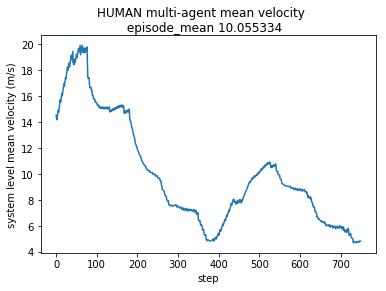

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for i in range(1):
    ax.plot(vel_lists[i])
title = AGENT + ' multi-agent mean velocity'
savepath = '../result/MultiAgent/' + AGENT + '/' + (title + ' ' + PATH).replace(' ', '_') + '.png'
title = title + ' \n episode_mean {:3f}'.format(np.mean(vel_lists))
ax.set_ylabel('system level mean velocity (m/s)')
ax.set_xlabel('step')
fig.suptitle(title)

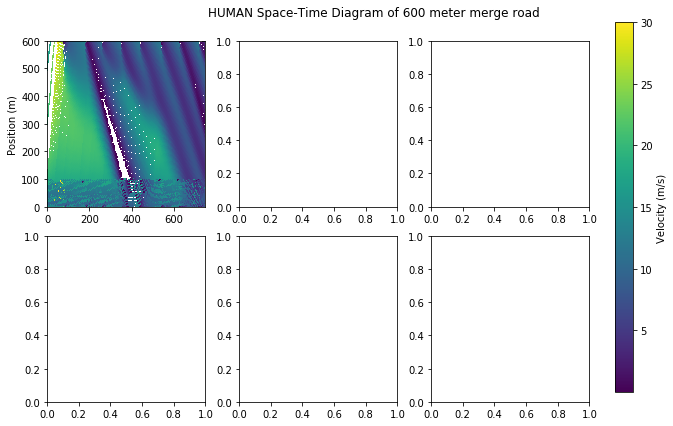

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
fig.tight_layout()

for i in range(1):
    # plt.subplot(2, 3, i+1)
    x = np.arange(int(env.env_params.horizon))
    y = np.arange(0, int(left_length), step=0.1)
    xx, yy = np.meshgrid(x, y)
    im = axes[i%2, i%3].pcolormesh(xx, yy, vel_map_lists[i].T)
    if i % 3 == 0:
        axes[i%2, i%3].set_ylabel('Position (m)')
    if int(i / 3.0) > 0:
        axes[int(i/3), int(i/3)].set_xlabel('step')
        
clb = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
clb.set_clim(0, 30)
clb.set_label('Velocity (m/s)')
title = AGENT + ' Space-Time Diagram of 600 meter merge road'
fig.suptitle(title)   
plt.subplots_adjust(top=0.9, right=0.8)
savepath = '../result/MultiAgent/' + AGENT + '/' + (title + ' ' + PATH).replace(' ', '_') + '.png'